# Configure Field Interpolation


Parcels comes with a number of different interpolation methods for tracer fields, such as temperature. Here, we will show how these work, in an idealised example. For more guidance on the sampling of such fields, check out the [sampling guide](./tutorial_sampling).

We first import the relevant modules


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_82767/647755831.py:5: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


We create a small 2D grid where `P` is a tracer that we want to interpolate. In each grid cell, `P` has a random value between 0.1 and 1.1. We then set `P[1,1]` to `0`, which for Parcels specifies that this is a land cell


In [ ]:
from parcels._datasets.structured.generated import simple_UV_dataset
ds = simple_UV_dataset(dims=(1, 1, 5, 4), mesh="flat").isel(time=0,depth=0)
ds["lat"][:] = np.linspace(0.0, 1.0, len(ds.YG))
ds["lon"][:] = np.linspace(0.0, 1.0, len(ds.XG))
dx, dy = 1.0 / len(ds.XG), 1.0 / len(ds.YG)
ds["P"] = ds["U"] + np.random.rand(5, 4) + 0.1
ds["P"][1, 1] = 0
ds

<xarray.Dataset> Size: 552B
Dimensions:  (YG: 5, XG: 4, YC: 5, XC: 4)
Coordinates:
    time     datetime64[ns] 8B 2000-01-01
    depth    float64 8B 0.0
  * YC       (YC) float64 40B 0.5 1.5 2.5 3.5 4.5
  * YG       (YG) int64 40B 0 1 2 3 4
  * XC       (XC) float64 32B 0.5 1.5 2.5 3.5
  * XG       (XG) int64 32B 0 1 2 3
    lat      (YG) float64 40B -90.0 -45.0 0.0 45.0 90.0
    lon      (XG) float64 32B -1e+06 -3.333e+05 3.333e+05 1e+06
Data variables:
    U        (YG, XG) float64 160B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    V        (YG, XG) float64 160B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

From this dataset we create a `parcels.FieldSet`. Parcels requires an interpolation method to be set for each `parcels.Field`, which we will later adapt to see the effects of the different interpolators. A common interpolator for fields on structured grids is (tri)linear, implemented in `parcels.interpolators.XLinear`.

In [ ]:
grid = parcels.XGrid.from_dataset(ds, mesh="flat")
U = parcels.Field("U", ds["U"], grid, interp_method=parcels.interpolators.XLinear)
V = parcels.Field("V", ds["V"], grid, interp_method=parcels.interpolators.XLinear)
UV = parcels.VectorField("UV", U, V)
P = parcels.Field("P", ds["P"], grid, interp_method=parcels.interpolators.XLinear)
fieldset = parcels.FieldSet([U, V, UV, P])

TypeError: Field.__init__() missing 1 required positional argument: 'interp_method'

We create a Particle class that can sample this field `P`.

In [4]:
SampleParticle = parcels.Particle.add_variable(
    parcels.Variable("p", dtype=np.float32, initial=np.nan)
)

def SampleP(particles, fieldset):
    particles.p = fieldset.P[particles]

Now, we perform four different interpolations on `P`, which we can control by setting `fieldset.P.interp_method`. Note that this can always be done _after_ the `FieldSet` creation. We store the results of each interpolation method in an entry in the dictionary `pset`.

In [9]:
pset = {}
from parcels.interpolators import XLinear, XLinearInvdistLandTracer, XNearest, CGrid_Tracer
interp_methods = [XLinear, XLinearInvdistLandTracer, XNearest, CGrid_Tracer]
for p_interp in interp_methods:
    fieldset.P.interp_method = (
        p_interp  # setting the interpolation method for fieldset.P
    )

    print(fieldset.P.interp_method.__name__)
    xv, yv = np.meshgrid(np.linspace(0, 1, 8), np.linspace(0, 1, 8))
    pset[p_interp.__name__] = parcels.ParticleSet(
        fieldset, pclass=SampleParticle, lon=xv.flatten(), lat=yv.flatten()
    )
    pset[p_interp.__name__].execute(SampleP, runtime=np.timedelta64(1,"D"), dt=np.timedelta64(1,"D"))

XLinear
Integration time: 0 seconds: 100%|██████████| 86400.0/86400.0 [00:00<00:00, 12953526.79it/s]
XLinearInvdistLandTracer
Integration time: 0 seconds:   0%|          | 0/86400.0 [00:00<?, ?it/s][ True False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True]
[ True False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True]
Integration time: 0 

/Users/Gebruiker/Documents/UU/parcels/Parcels/src/parcels/interpolators.py:624: RuntimeWarning: divide by zero encountered in divide
  inv_dist = 1.0 / dist2
/Users/Gebruiker/Documents/UU/parcels/Parcels/src/parcels/interpolators.py:630: RuntimeWarning: invalid value encountered in divide
  values[some_land] = val[some_land] / w_sum[some_land]


And then we can show each of the four interpolation methods, by plotting the interpolated values on the `Particles` locations (circles) on top of the `Field` values (background colors)


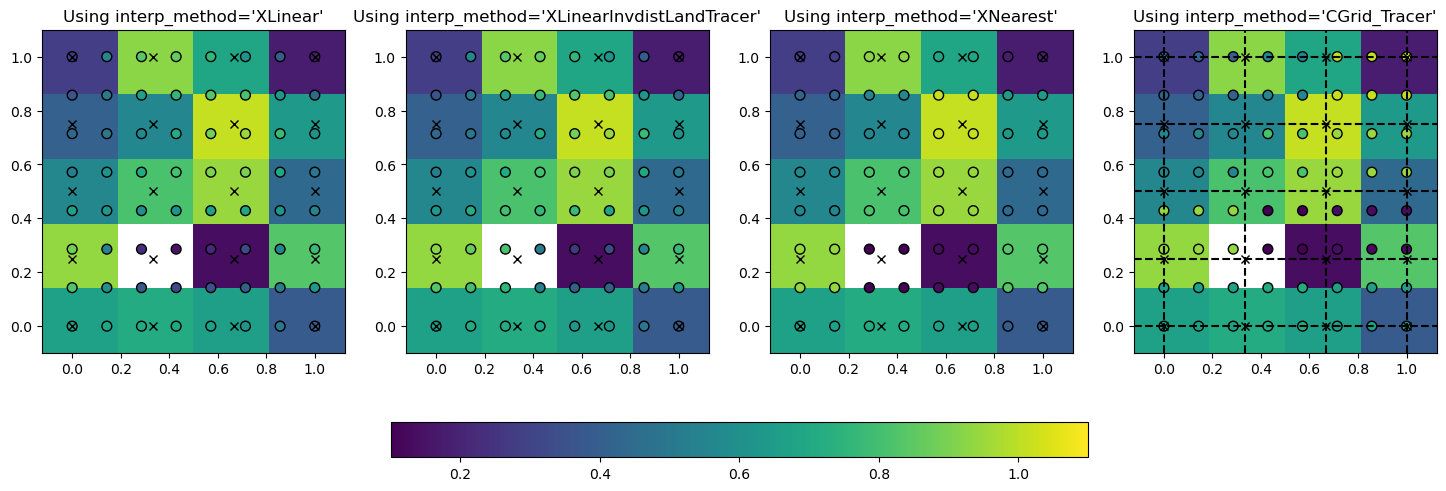

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
for i, p in enumerate(pset.keys()):
    data = np.copy(fieldset.P.data[0, 0, :, :])
    data[1, 1] = np.nan
    x = np.linspace(-dx / 2, 1 + dx / 2, len(ds.XG) + 1)
    y = np.linspace(-dy / 2, 1 + dy / 2, len(ds.YG) + 1)
    if p == "CGrid_Tracer":
        for lat in fieldset.P.grid.lat:
            ax[i].axhline(lat, color="k", linestyle="--")
        for lon in fieldset.P.grid.lon:
            ax[i].axvline(lon, color="k", linestyle="--")
    pc = ax[i].pcolormesh(x, y, data, vmin=0.1, vmax=1.1)
    ax[i].scatter(
        pset[p].lon, pset[p].lat, c=pset[p].p, edgecolors="k", s=50, vmin=0.1, vmax=1.1
    )
    xp, yp = np.meshgrid(fieldset.P.grid.lon, fieldset.P.grid.lat)
    ax[i].plot(xp, yp, "kx")
    ax[i].set_title(f"Using interp_method='{p}'")
plt.colorbar(pc, ax=ax, orientation="horizontal", shrink=0.5)
plt.show()

The white box is here the 'land' point where the tracer is set to zero and the crosses are the locations of the grid points. As you see, the interpolated value is always equal to the field value if the particle is exactly on the grid point (circles on crosses).

For `interp_method='XNearest'`, the particle values are the same for all particles in a grid cell. They are also the same for `interp_method='CGrid_Tracer'`, but the grid cells have then shifted. That is because in a C-grid, the tracer grid cell is on the top-right corner (black dashed lines in right-most panel).

For `interp_method='XLinearInvdistLandTracer'`, we see that values are the same as `interp_method='XLinear'` for grid cells that don't border the land point. For grid cells that do border the land cell, the `XLinearInvdistLandTracer` interpolation method gives higher values, as also shown in the difference plot below.


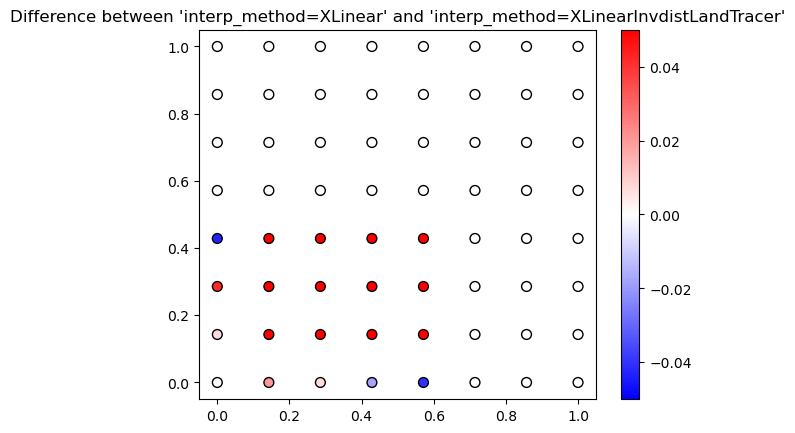

In [10]:
plt.scatter(
    pset["XLinear"].lon,
    pset["XLinear"].lat,
    c=pset["XLinearInvdistLandTracer"].p - pset["XLinear"].p,
    edgecolors="k",
    s=50,
    cmap=cm.bwr,
    vmin=-0.05,
    vmax=0.05,
)
plt.colorbar()
plt.title(
    "Difference between 'interp_method=XLinear' "
    "and 'interp_method=XLinearInvdistLandTracer'"
)
plt.show()

So in summary, Parcels has four different interpolation schemes for tracers:

1. `interp_method=parcels.interpolators.XLinear`: compute linear interpolation
2. `interp_method=parcels.interpolators.XLinearInvdistLandTracer`: compute linear interpolation except near land (where field value is zero). In that case, inverse distance weighting interpolation is computed, weighting by squares of the distance.
3. `interp_method=parcels.interpolators.XNearest`: return nearest field value
4. `interp_method=parcels.interpolators.CGridTracer`: return nearest field value supposing C cells
